In [ ]:
#import lsbd and dask to combine the analysis of DP1 and the sim

In [1]:
from main import SimCatVal
afw_img, cat, match, area = SimCatVal('/hildafs/home/pladuca/main/skyCatalog.yaml',250, 'i', 50, 0.7, 0.1, 30, True)

2025-11-13 18:34:06,381 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


Generating Sims


2025-11-13 18:34:10,020 - INFO - Working on healpix pixel 10307
2025-11-13 18:34:12,797 - INFO - Working on healpix pixel 10307


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Pipeline


  0%|          | 0/1 [00:00<?, ?it/s]

      coord_ra     
        rad        
-------------------
0.17746674215978903
0.17731559048893802
0.17734360445995787
 0.1772683515022203
0.17737101266924554
0.17730471233190795
0.17739019775983964
0.17746104799613435
0.17747296659067435
                ...
 0.1773444698685438
0.17737983092398923
0.17721148174813994
0.17724952924328724
0.17736683809764406
0.17727224386684365
0.17741801267983415
 0.1774659828771756
 0.1773906774212323
0.17734175827515689
Length = 34 rows


In [2]:
print(len(cat[0]))
print(len(match[0]))

34
34


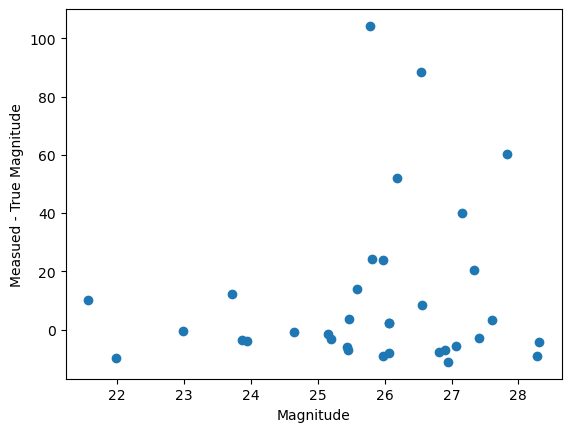

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def compare_matches(matches, coadd_zp):
    mag = matches['mag']
    mag_t = -2.5*np.log10(matches['flux']) + coadd_zp
    dif = (mag - mag_t) / mag
    dif = (matches['modelfit_CModel_instFlux'] - matches['flux'])/matches['flux'] * 100
    plt.scatter(mag, dif)
    plt.xlabel('Magnitude')
    plt.ylabel('Measued - True Magnitude')
    # plt.yscale('log')
    plt.show()
compare_matches(match[0], 30)


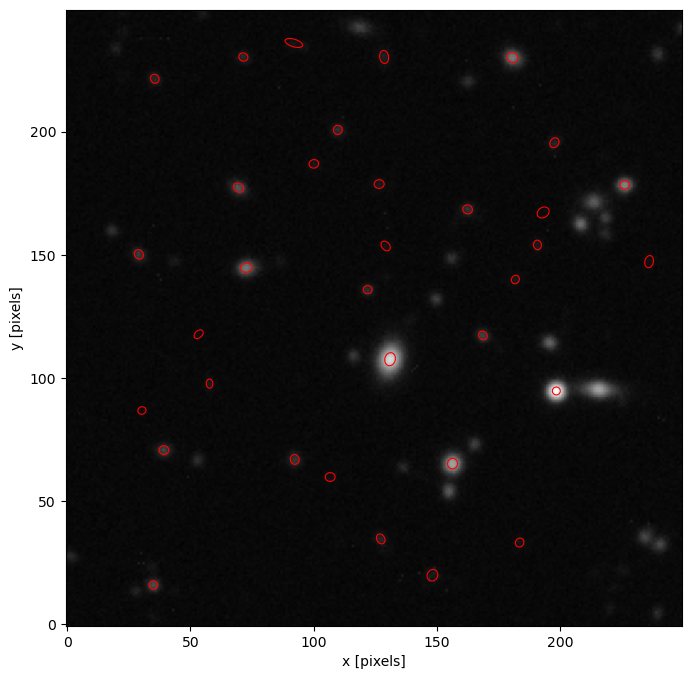

In [4]:
from matplotlib.patches import Ellipse
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, AsinhStretch
#from lsst.geom import SpherePoint, degrees

def plot_sim_image(afw_img, cat=None):
    img = afw_img.image.array
    wcs = afw_img.wcs
    norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=AsinhStretch(0.03))
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img, origin='lower', cmap='gray', norm=norm) #apply a sinh stretch?
    if cat != None:
        for i in range(len(cat)):
            # sp = SpherePoint(cat['coord_ra'] * degrees, cat['coord_dec'] * degrees)
            # point = wcs.skyToPixel(sp)
            # x=point.getX()
            # y=point.getY()
            x = cat['base_SdssCentroid_x'][i]
            y = cat['base_SdssCentroid_y'][i]
            xx = cat['base_SdssShape_xx'][i]
            yy = cat['base_SdssShape_yy'][i]
            xy = cat['base_SdssShape_xy'][i]

            T = 0.5 * (xx + yy)
            D = np.sqrt(((xx - yy) / 2)**2 + xy**2)
            a = np.sqrt(T + D)
            b = np.sqrt(T - D)
            theta = 0.5 * np.arctan2(2 * xy, xx - yy)
            
            e = Ellipse((x, y), width=2*a, height=2*b,
                        angle=np.degrees(theta), edgecolor='red',
                        facecolor='none', lw=0.8)
            ax.add_patch(e)
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    plt.show()

plot_sim_image(afw_img[0], cat[0])